# PINN to solve Navier-Stokes Equation

Implemention of the Physics Informed Neural Network (PINN) model for the cavity flow governed by the equation of continuity and the steady Navier-Stokes equation in two dimensions. They are given by



```
u_r + v_z = 0
u*u_r + v*u_z + p_r/rho - nu*(u_rr + u_zz) = 0
u*v_r + v*v_z + p_z/rho - nu*(v_rr + v_zz) = 0
```


where (u, v) is the flow velocity, p is the pressure, _r, _z indicate 1st derivatives d/dr, d/dz, _rr, _zz indicate 2nd derivatives d2/dr2, d2/dz2, rho is the density and nu is the viscosity. To fill the equation of continuity automatically, he sake of simplicity, we use the stream function psi given by (u = psi_z, v = -psi_r). For the cavity flow in the range r, z = 0 ~ 1, we give boundary conditions: u=0, v=1 at top boundary; u=0, v=0 at other boundaries, where Reynolds number Re=100 for rho=1 and nu=0.01. The PINN model predicts (psi, p) for the input (r, z).

In [ ]:
import  tensorflow  as  tf 
import  scipy.optimize 
import  numpy  as  np 
import  matplotlib.pyplot  as  plt 
from  matplotlib.colors  import  Normalize 
from  matplotlib.gridspec  import  GridSpec 
import  pandas  as  pd
import math
from sklearn.metrics import mean_squared_error

In [ ]:
class GradientLayer(tf.keras.layers.Layer):
    """
    Custom layer to compute derivatives for the steady Navier-Stokes equation.
    Attributes:
        model: keras network model.
    """
    def __init__(self, model, **kwargs):
        """
        Args:
            model: keras network model.
        """

        self.model = model
        super().__init__(**kwargs)

    def call(self, xy):
        """
        Computing derivatives for the steady Navier-Stokes equation.
        Args:
            xy: input variable.
        Returns:
            psi: stream function.
            p_grads: pressure and its gradients.
            u_grads: u and its gradients.
            v_grads: v and its gradients.
        """

        x, y = [ xy[..., i, tf.newaxis] for i in range(xy.shape[-1]) ]
        with tf.GradientTape(persistent=True) as ggg:
            ggg.watch(x)
            ggg.watch(y)
            with tf.GradientTape(persistent=True) as gg:
                gg.watch(x)
                gg.watch(y)
                with tf.GradientTape(persistent=True) as g:
                    g.watch(x)
                    g.watch(y)
                    psi_p = self.model(tf.concat([x, y], axis=-1))
                    psi = psi_p[..., 0, tf.newaxis]
                    p   = psi_p[..., 1, tf.newaxis]
                u   =  g.batch_jacobian(psi, y)[..., 0]
                v   = -g.batch_jacobian(psi, x)[..., 0]
                p_x =  g.batch_jacobian(p,   x)[..., 0]
                p_y =  g.batch_jacobian(p,   y)[..., 0]
                del g
            u_x = gg.batch_jacobian(u, x)[..., 0]
            u_y = gg.batch_jacobian(u, y)[..., 0]
            v_x = gg.batch_jacobian(v, x)[..., 0]
            v_y = gg.batch_jacobian(v, y)[..., 0]
            del gg
        u_xx = ggg.batch_jacobian(u_x, x)[..., 0]
        u_yy = ggg.batch_jacobian(u_y, y)[..., 0]
        v_xx = ggg.batch_jacobian(v_x, x)[..., 0]
        v_yy = ggg.batch_jacobian(v_y, y)[..., 0]
        del ggg

        p_grads = p, p_x, p_y
        u_grads = u, u_x, u_y, u_xx, u_yy
        v_grads = v, v_x, v_y, v_xx, v_yy

        return psi, p_grads, u_grads, v_grads

In [ ]:
class Network:
    """
    Build a physics informed neural network (PINN) model for the steady Navier-Stokes equations.
    Attributes:
        activations: custom activation functions.
    """

    def __init__(self):
        """
        Setup custom activation functions.
        """
        self.activations = {
            'tanh' : 'tanh',
            'swish': self.swish,
            'mish' : self.mish,
        }

    def swish(self, r):
        """
        Swish activation function.
        Args:
            r: activation input.
        Returns:
            Swish output.
        """
        return r * tf.math.sigmoid(r)

    def mish(self, r):
        """
        Mish activation function.
        Args:
            r: activation input.
        Returns:
            Mish output.
        """
        return r * tf.math.tanh(tf.softplus(r))

    def build(self, num_inputs=2, layers=[32, 16, 16, 32], activation='swish', num_outputs=2):
        """
        Build a PINN model for the steady Navier-Stokes equation with input shape (r,z) and output shape (psi, p).
        Args:
            num_inputs: number of input variables. Default is 2 for (r, z).
            layers: number of hidden layers.
            activation: activation function in hidden layers.
            num_outpus: number of output variables. Default is 2 for (psi, p).
        Returns:
            keras network model
        """

        # input layer
        inputs = tf.keras.layers.Input(shape=(num_inputs,))
        # hidden layers
        r = inputs
        for layer in layers:
            r = tf.keras.layers.Dense(layer, activation=self.activations[activation],
                kernel_initializer='he_normal')(r)
        # output layer
        outputs = tf.keras.layers.Dense(num_outputs,
            kernel_initializer='he_normal')(r)

        return tf.keras.models.Model(inputs=inputs, outputs=outputs)

In [ ]:
class PINN:
    """
    Build a physics informed neural network (PINN) model for the steady Navier-Stokes equation.
    Attributes:
        network: keras network model with input (r, z) and output (psi, p).
        rho: density.
        nu: viscosity.
        grads: gradient layer.
    """

    def __init__(self, network, rho=1, nu=0.01,init_p=0):
        """
        Args:
            network: keras network model with input (r, z) and output (psi, p).
            rho: density.
            nu: viscosity.
            init_p : initial pressure p(0)
        """

        self.network = network
        self.rho = rho
        self.nu = nu
        self.init_p = init_p
        self.grads = GradientLayer(self.network)

    def build(self):
        """
        Build a PINN model for the steady Navier-Stokes equation.
        Returns:
            PINN model for the steady Navier-Stokes equation with
                input: [ (r, z) relative to equation,
                         (r, z) relative to boundary condition ],
                output: [ (u, v) relative to equation (must be zero),
                          (psi, psi) relative to boundary condition (psi is duplicated because outputs require the same dimensions),
                          (u, v) relative to boundary condition ]
        """

        # equation input: (r, z)
        rz_eqn = tf.keras.layers.Input(shape=(2,))
        # boundary condition
        rz_bnd = tf.keras.layers.Input(shape=(2,))

        # compute gradients relative to equation
        _, p_grads, u_grads, v_grads = self.grads(rz_eqn)
        _, p_r, p_z = p_grads
        u, u_r, u_z, u_rr, u_zz = u_grads
        v, v_r, v_z, v_rr, v_zz = v_grads
        # compute equation loss
        u_eqn = u*u_r + v*u_z + p_r/self.rho - self.nu*(u_rr + u_zz)
        v_eqn = u*v_r + v*v_z + (p_z + self.init_p)/self.rho - self.nu*(v_rr + v_zz)
        uv_eqn = tf.concat([u_eqn, v_eqn], axis=-1)

        # compute gradients relative to boundary condition
        psi_bnd, _, u_grads_bnd, v_grads_bnd = self.grads(rz_bnd)
        # compute boundary condition loss
        psi_bnd = tf.concat([psi_bnd, psi_bnd], axis=-1)
        uv_bnd = tf.concat([u_grads_bnd[0], v_grads_bnd[0]], axis=-1)

        # build the PINN model for the steady Navier-Stokes equation
        return tf.keras.models.Model(
            inputs=[rz_eqn, rz_bnd], outputs=[uv_eqn, psi_bnd, uv_bnd])

In [ ]:
class L_BFGS_B:
    """
    Optimize the keras network model using L-BFGS-B algorithm.
    Attributes:
        model: optimization target model.
        samples: training samples.
        factr: function convergence condition. typical values for factr are: 1e12 for low accuracy;
               1e7 for moderate accuracy; 10.0 for extremely high accuracy.
        pgtol: gradient convergence condition.
        m: maximum number of variable metric corrections used to define the limited memory matrix.
        maxls: maximum number of line search steps (per iteration).
        maxiter: maximum number of iterations.
        metris: log metrics
        progbar: progress bar
    """

    def __init__(self, model, r_train, z_train, factr=10, pgtol=1e-10, m=50, maxls=50, maxiter=20):
        """
        Args:
            model: optimization target model.
            samples: training samples.
            factr: convergence condition. typical values for factr are: 1e12 for low accuracy;
                   1e7 for moderate accuracy; 10.0 for extremely high accuracy.
            pgtol: gradient convergence condition.
            m: maximum number of variable metric corrections used to define the limited memory matrix.
            maxls: maximum number of line search steps (per iteration).
            maxiter: maximum number of iterations.
        """

        # set attributes
        self.model = model
        self.r_train = [ tf.constant(r, dtype=tf.float32) for r in r_train ]
        self.z_train = [ tf.constant(z, dtype=tf.float32) for z in z_train ]
        self.factr = factr
        self.pgtol = pgtol
        self.m = m
        self.maxls = maxls
        self.maxiter = maxiter
        self.metrics = ['loss']
        # initialize the progress bar
        self.progbar = tf.keras.callbacks.ProgbarLogger(
            count_mode='steps', stateful_metrics=self.metrics)
        self.progbar.set_params( {
            'verbose':1, 'epochs':1, 'steps':self.maxiter, 'metrics':self.metrics})

    def set_weights(self, flat_weights):
        """
        Set weights to the model.
        Args:
            flat_weights: flatten weights.
        """

        # get model weights
        shapes = [ w.shape for w in self.model.get_weights() ]
        # compute splitting indices
        split_ids = np.cumsum([ np.prod(shape) for shape in [0] + shapes ])
        # reshape weights
        weights = [ flat_weights[from_id:to_id].reshape(shape)
            for from_id, to_id, shape in zip(split_ids[:-1], split_ids[1:], shapes) ]
        # set weights to the model
        self.model.set_weights(weights)

    @tf.function
    def tf_evaluate(self, r, z):
        """
        Evaluate loss and gradients for weights as tf.Tensor.
        Args:
            r: input data.
        Returns:
            loss and gradients for weights as tf.Tensor.
        """

        with tf.GradientTape() as g:
            loss = tf.reduce_mean(tf.keras.losses.logcosh(self.model(r), z))
        grads = g.gradient(loss, self.model.trainable_variables)
        return loss, grads

    def evaluate(self, weights):
        """
        Evaluate loss and gradients for weights as ndarray.
        Args:
            weights: flatten weights.
        Returns:
            loss and gradients for weights as ndarray.
        """

        # update weights
        self.set_weights(weights)
        # compute loss and gradients for weights
        loss, grads = self.tf_evaluate(self.r_train, self.z_train)
        # convert tf.Tensor to flatten ndarray
        loss = loss.numpy().astype('float64')
        grads = np.concatenate([ g.numpy().flatten() for g in grads ]).astype('float64')

        return loss, grads

    def callback(self, weights):
        """
        Callback that prints the progress to stdout.
        Args:
            weights: flatten weights.
        """
        self.progbar.on_batch_begin(0)
        loss, _ = self.evaluate(weights)
        self.progbar.on_batch_end(0, logs=dict(zip(self.metrics, [loss])))

    def fit(self):
        """
        Train the model using L-BFGS-B algorithm.
        """

        # get initial weights as a flat vector
        initial_weights = np.concatenate(
            [ w.flatten() for w in self.model.get_weights() ])
        # optimize the weight vector
        print('Optimizer: L-BFGS-B (maxiter={})'.format(self.maxiter))
        self.progbar.on_train_begin()
        self.progbar.on_epoch_begin(1)
        scipy.optimize.fmin_l_bfgs_b(func=self.evaluate, x0=initial_weights,
            factr=self.factr, pgtol=self.pgtol, m=self.m,
            maxls=self.maxls, maxiter=self.maxiter, callback=self.callback)
        self.progbar.on_epoch_end(1)
        self.progbar.on_train_end()

In [ ]:
def uv(network, rz):
    """
    Compute flow velocities (u, v) for the network with output (psi, p).
    Args:
        rz: network input variables as ndarray.
    Returns:
        (u, v) as ndarray.
    """

    rz = tf.constant(rz)
    with tf.GradientTape() as g:
        g.watch(rz)
        psi_p = network(rz)
        
    psi_p_j = g.batch_jacobian(psi_p, rz)
    u =  psi_p_j[..., 0, 1]
    v = -psi_p_j[..., 0, 0]
    return u.numpy(), v.numpy()

def contour(grid, x, y, z, title, levels=50):
    """
    Contour plot.
    Args:
        grid: plot position.
        x: x-array.
        y: y-array.
        z: z-array.
        title: title string.
        levels: number of contour lines.
    """

    # get the value range
    vmin = np.min(z)
    vmax = np.max(z)
    # plot a contour
    plt.subplot(grid)
    plt.contour(x, y, z, colors='k', linewidths=0.2, levels=levels)
    plt.contourf(x, y, z, cmap='rainbow', levels=levels, norm=Normalize(vmin=vmin, vmax=vmax))
    plt.title(title)
    cbar = plt.colorbar(pad=0.03, aspect=25, format='%.0e')
    cbar.mappable.set_clim(vmin, vmax)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 32)                96        
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 32)                544       
                                                                 
 dense_4 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1,506
Trainable params: 1,506
Non-trainable par

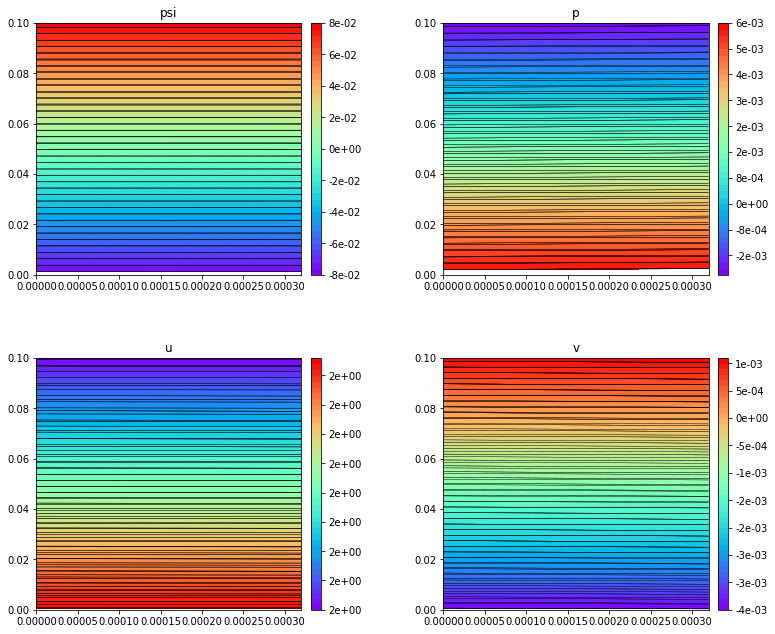

In [ ]:
"""
    Test the physics informed neural network (PINN) model
    for the cavity flow governed by the steady Navier-Stokes equation.
"""

# number of training samples
num_train_samples = 1000
# number of test samples
num_test_samples = 100

# inlet flow velocity
u0 = 1.57
# density
rho = 1.075
# viscosity
nu = 18.17e-6

# build a core network model
network = Network().build()
network.summary()
# build a PINN model
pinn = PINN(network, rho=rho, nu=nu).build()
df = pd.read_csv('../Data/gen0/boundary_0.csv')
X = df[['r','z']]
X_copy = X
# create training input
rz_eqn = X_copy.sample(n = 1000)
rz_ub = X[0:500]  # top-bottom boundaries
rz_lb = X[19801:]  # top-bottom boundaries 
rz_bnd = np.random.permutation(np.concatenate([rz_ub, rz_lb]))
r_train = [rz_eqn, rz_bnd]

# create training output
zeros = np.zeros((num_train_samples, 2))
uv_bnd = np.zeros((num_train_samples, 2))
uv_bnd[..., 0] = u0
z_train = [zeros, zeros, uv_bnd]

# train the model using L-BFGS-B algorithm
lbfgs = L_BFGS_B(model=pinn, r_train=r_train, z_train=z_train)
lbfgs.fit()

# create meshgrid coordinates (x, y) for test plots

z = df['z'][0:1000]
print(z.shape)
r = df['r'][0:1000]
print(r.shape)
r, z = np.meshgrid(r, z)
rz = np.stack([r.flatten(), z.flatten()], axis=-1)
# predict (psi, p)
psi_p = network.predict(rz, batch_size=len(rz))
print(psi_p.shape)
psi, p = [ psi_p[..., i].reshape(r.shape) for i in range(psi_p.shape[-1]) ]

# compute (u, v)
u, v = uv(network, rz)

u = u.reshape(r.shape)
v = v.reshape(r.shape)

# plot test results

fig = plt.figure(figsize=(12, 10))
gs = GridSpec(2, 2)
contour(gs[0, 0], r, z, psi, 'psi')
contour(gs[0, 1], r, z, p, 'p')
contour(gs[1, 0], r, z, u, 'u')
contour(gs[1, 1], r, z, v, 'v')
plt.tight_layout(pad=5)
plt.show()

### Result Generation
In order to generated simulations for other generations, in the above code change the dataframe df to the data file you want to simulate. For the boundary conditions, let's say you want to simulate for generation-0, go to the file 'Evaluation_points_Gen_0.xlsx', in this file 12 different boundary conditions are given, let's say you choose 2nd boundary condition P(0) = 101325,  v_z(0) = 1.96, so change init_p in the code of PINN class to value of P(0) and u_0 in the code to value of v_z(0), set the path of the file read into the dataframe df in the code as path of 'boundary_2.csv' in the gen0 folder and the simulation can be performed now.

#### Calculating RMSE Loss

In [ ]:
# calculated values
Y_pred=[]
for x in p:
  Y_pred.append(x[-1])

# Given values
Y_true = np.array(df['P'][0:1000])

# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(Y_true,Y_pred)
rmse = math.sqrt(mse)
rmse